## **Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Data Visualization**

Found 2239 files belonging to 9 classes.


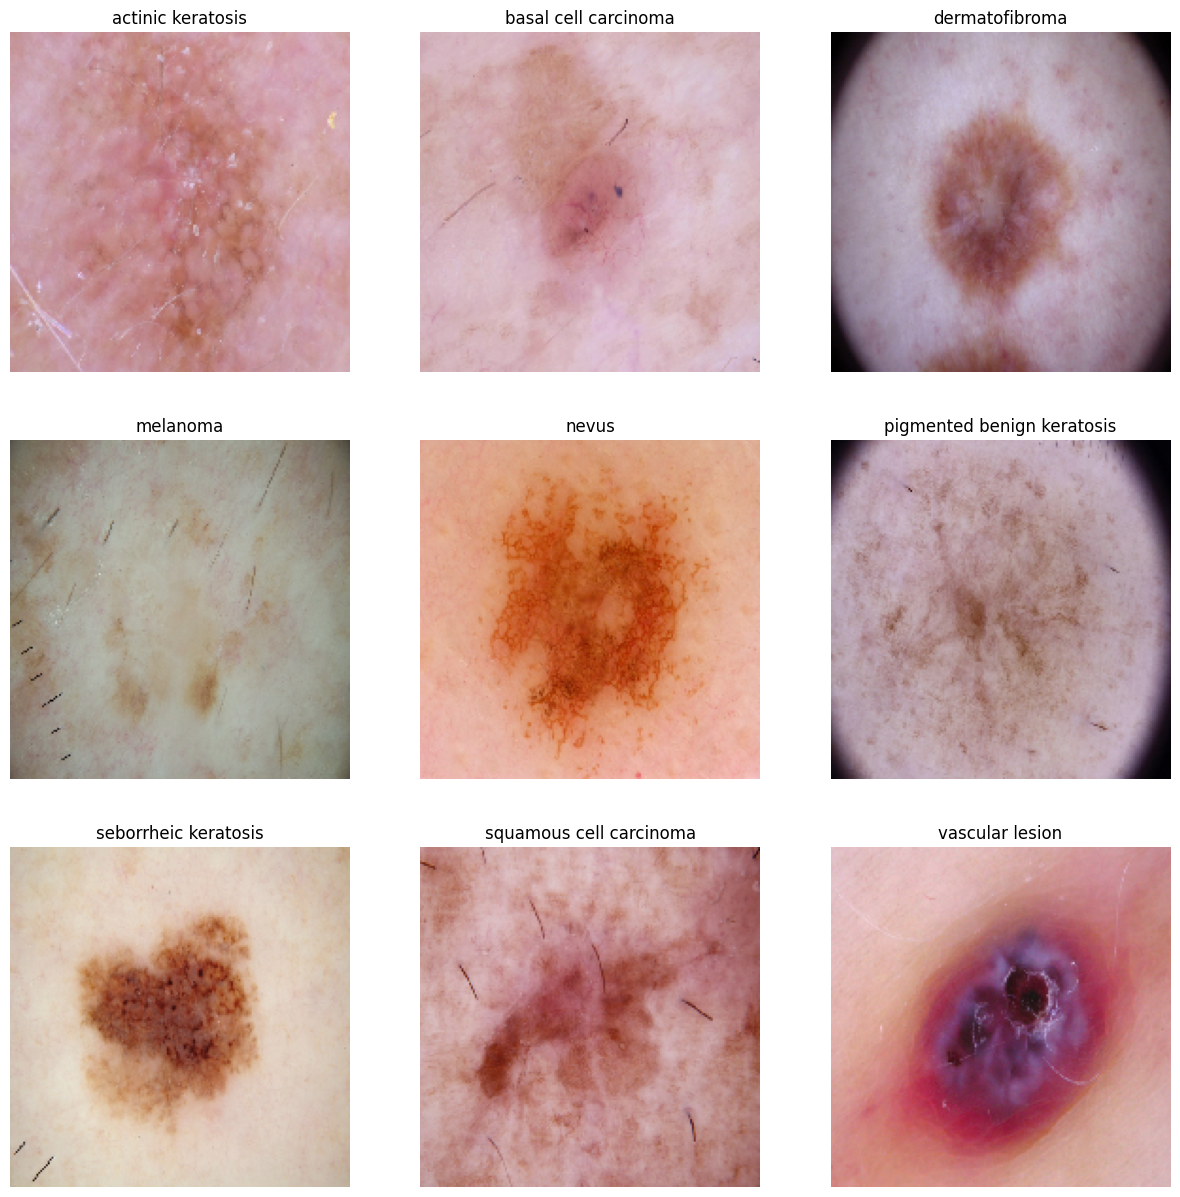

In [6]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### **Visualize distribution of classes in the training dataset.**

In [7]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,basal cell carcinoma,376
1,vascular lesion,139
2,pigmented benign keratosis,462
3,seborrheic keratosis,77
4,nevus,357
5,actinic keratosis,114
6,squamous cell carcinoma,181
7,dermatofibroma,95
8,melanoma,438


**Which class has the least number of samples?**

seborrheic keratosis

**Which classes dominate the data in terms of the proportionate number of samples?**

melanoma

pigmented benign keratosis

<Axes: xlabel='No. of Image', ylabel='Class'>

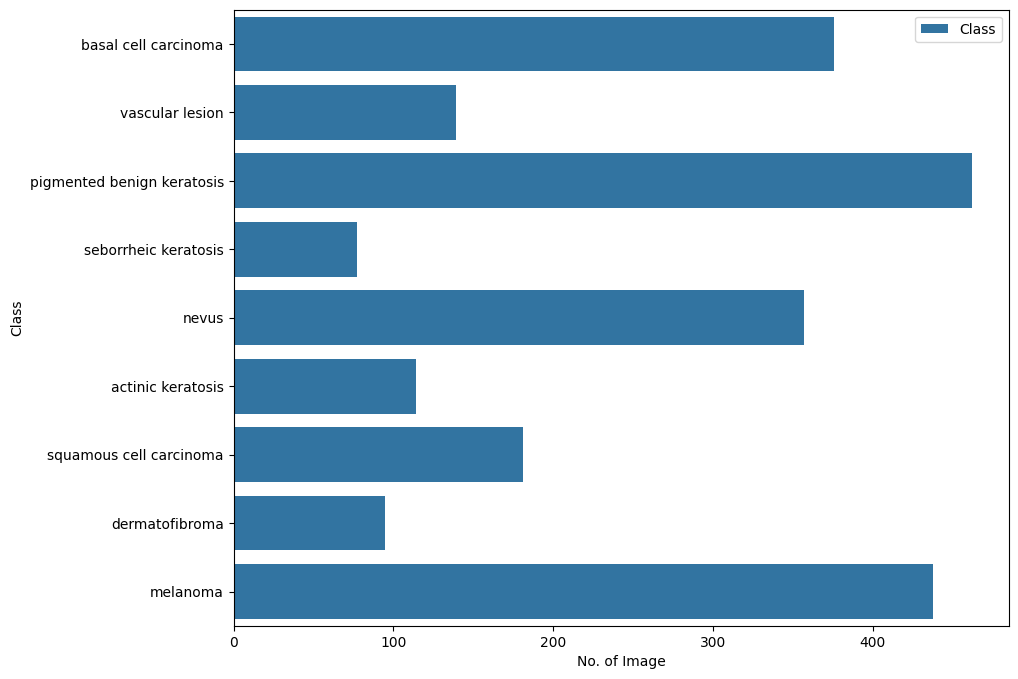

In [8]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

##### **Observation:**
There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [9]:
#install Augmentor
!pip install Augmentor

In [10]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF3EE582530>: 100%|██████████| 500/500 [00:17<00:00, 29.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF40FF9F5E0>: 100%|██████████| 500/500 [00:19<00:00, 26.06 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CF43BF5BB50>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF4CE60D8D0>: 100%|██████████| 500/500 [01:22<00:00,  6.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7CF40FF73340>: 100%|██████████| 500/500 [01:07<00:00,  7.38 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF3B892C640>: 100%|██████████| 500/500 [00:15<00:00, 32.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CF4200E7430>: 100%|██████████| 500/500 [00:33<00:00, 14.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CF4385F1990>: 100%|██████████| 500/500 [00:15<00:00, 33.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CF440153FD0>: 100%|██████████| 500/500 [00:14<00:00, 34.02 Samples/s]


In [11]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### **Model Building**

In [12]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [13]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [14]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

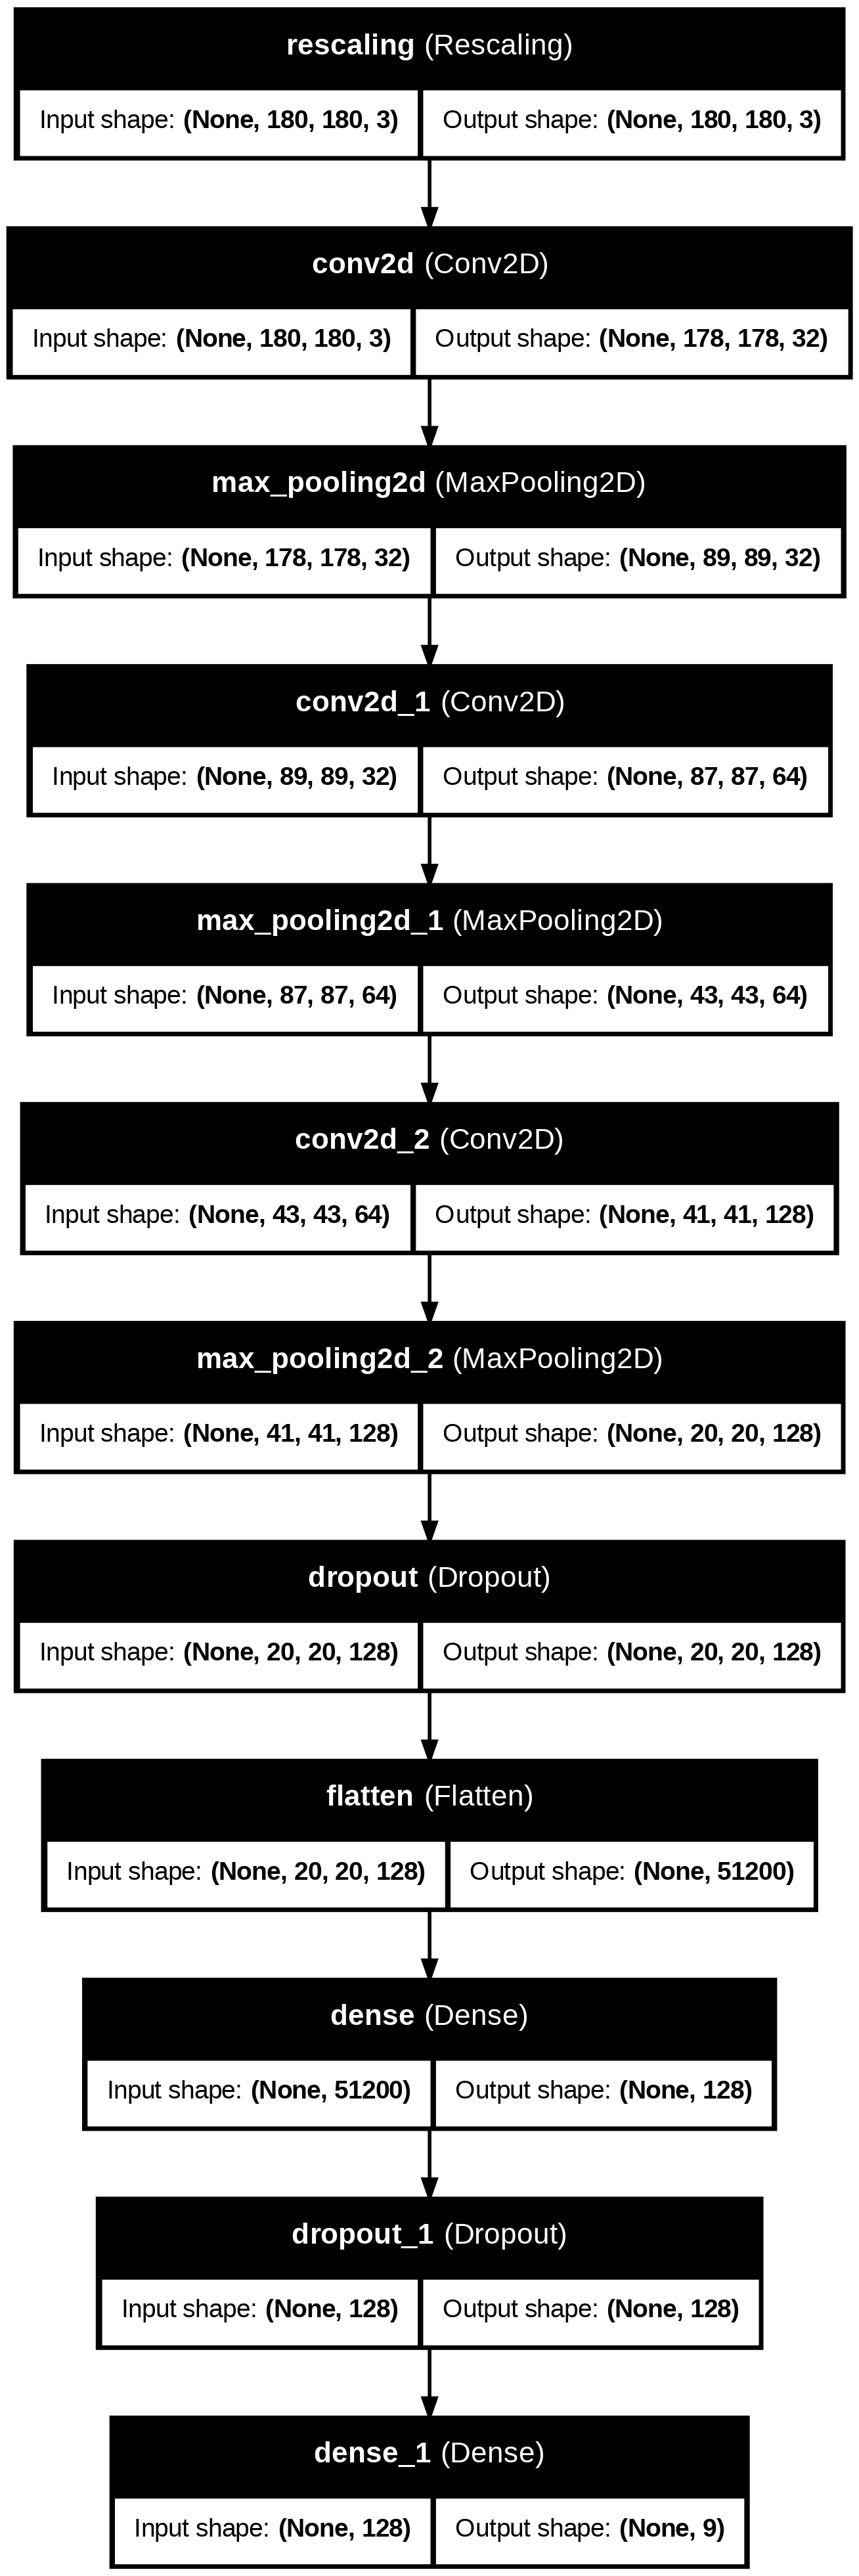

In [16]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### **Compile the model**


In [17]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


### **Train the model**

In [18]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2000 - loss: 2.1243
Epoch 1: val_accuracy improved from -inf to 0.33630, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.2008 - loss: 2.1218 - val_accuracy: 0.3363 - val_loss: 1.7026
Epoch 2/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3822 - loss: 1.6030
Epoch 2: val_accuracy improved from 0.33630 to 0.49443, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.3825 - loss: 1.6023 - val_accuracy: 0.4944 - val_loss: 1.3674
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4644 - loss: 1.4080
Epoch 3: val_accuracy improved from 0.49443 to 0.52487, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4645 - loss: 1.4078 - val_accuracy: 0.5249 - val_loss: 1.2546
Epoch 4/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5160 - loss: 1.2734
Epoch 4: val_accuracy improved from 0.52487 to 0

### **Visualizing training results:**


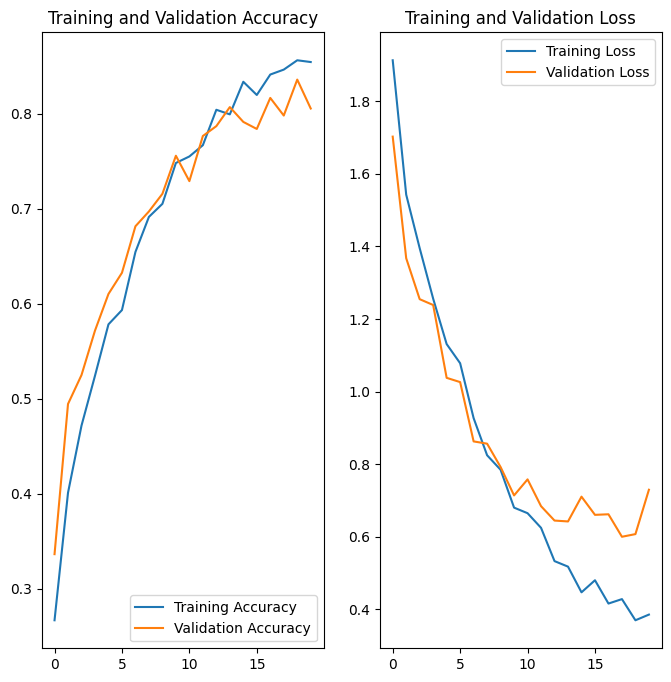

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### **1. Evidence of Overfitting or Underfitting**
Initial Epochs (1–10):

**Training Accuracy:** Rose from 20% → 76.8%.
Validation Accuracy: Increased from 33.6% → 75.6%.

Observation: The model was learning well, with validation closely following training performance → No overfitting or underfitting.
Later Epochs (11–20):

**Training Accuracy:** Peaked at 85.9%.

**Validation Accuracy:** Plateaued around 80.5–83.6%.

**Validation Loss:** Decreased until Epoch 13 but started fluctuating afterward, reaching 0.72 in the last epoch.

Observation: The growing gap between training and validation accuracy along with rising validation loss suggests mild overfitting.

**2. Overfitting Indicators**

**Validation Accuracy Stagnation:**
Validation accuracy did not improve beyond 83.6%, while training accuracy continued to rise.

**Validation Loss Fluctuation:**
Validation loss increased slightly after Epoch 13, even when training loss kept decreasing.

**Dropout Layers:**
Although Dropout (0.5 and 0.25) was applied, overfitting still occurred in later epochs.

**3. Underfitting Evaluation**

**Early Learning Phase:**
1. Both training and validation accuracies improved steadily.
2. No significant gap between training and validation performance in early epochs.
Conclusion: No evidence of underfitting.

**4. Recommendations for Improvement**
**Combat Overfitting:**

1. Introduce Data Augmentation (rotation, zoom, flips).
2. Apply L2 Regularization in convolutional and dense layers.
3. Add Batch Normalization to stabilize and accelerate learning.
4. Implement Early Stopping to halt training when validation performance stops improving.

**Model Complexity:**

Slightly increase the network depth or filter sizes.
Use learning rate scheduling to fine-tune training progression.




#### **Applying above recommendations on the model**

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# 1. Data Augmentation Layer (Integrated into the model)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])


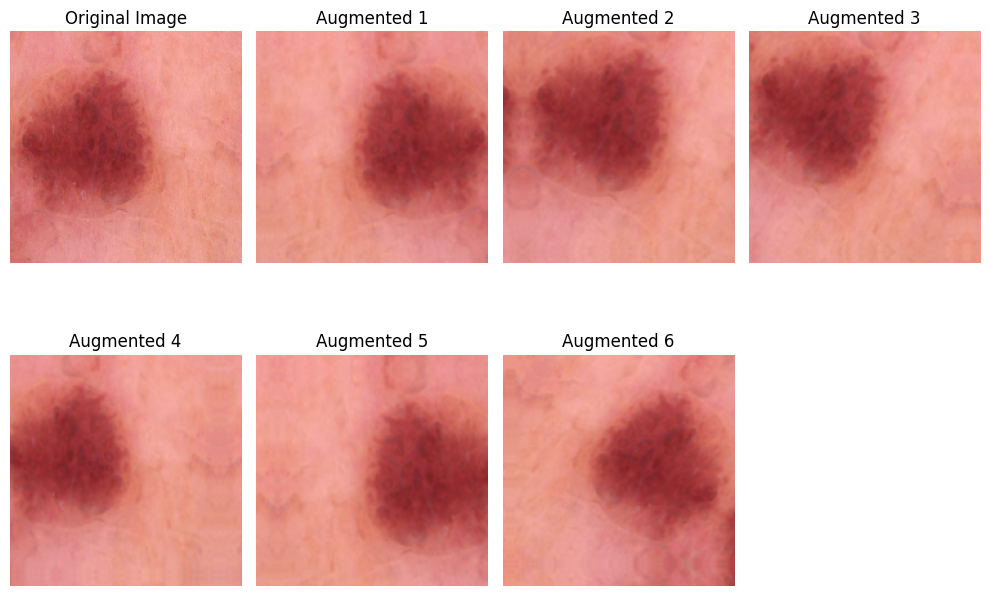

In [21]:
# Visualize how your augmentation strategy works for one instance of training image
# Generate augmented images
import matplotlib.pyplot as plt

# Extract one batch of images and labels
for images, labels in train_ds.take(1):
    sample_images = images[:1]  # Take the first image

# Apply augmentation to the sample image
augmented_images = [data_augmentation(sample_images, training=True)[0].numpy().astype("uint8") for _ in range(6)]

# Plot original and augmented images
plt.figure(figsize=(10, 7))

# Original Image
plt.subplot(2, 4, 1)
plt.imshow(sample_images[0].numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Augmented Images
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 4, i + 2)
    plt.imshow(augmented_img)
    plt.title(f"Augmented {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
#CNN Model Architecture

# 2. Model Architecture with Batch Normalization
# Sequential Model
model = Sequential()

# Data Augmentation Layer
model.add(data_augmentation)

# Data Normalization
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout for Regularization
model.add(layers.Dropout(0.4))  # Reduced from 0.5

# Flatten the Feature Maps
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Reduced from 0.25

# Output Layer with Correct Class Size
model.add(layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (1, 180, 180, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (1, 180, 180, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (1, 90, 90, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (1, 90, 90, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (1, 90, 90, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (1, 45, 45, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (1, 45, 45, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (1, 45, 45, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (1, 61952)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 128)                    │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (1, 128)                    │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 9)                      │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,025,801 (30.62 MB)

 Trainable params: 8,025,097 (30.61 MB)

 Non-trainable params: 704 (2.75 KB)

### Compiling the model

In [31]:
## Your code goes here
# 3. Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Learning Rate Scheduler

In [32]:
# 4. Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

### Early Stopping

In [33]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.3003 - loss: 2.1552 - val_accuracy: 0.1151 - val_loss: 2.6830 - learning_rate: 0.0010
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.4344 - loss: 1.5622 - val_accuracy: 0.2316 - val_loss: 1.9975 - learning_rate: 0.0010
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.4251 - loss: 1.5449 - val_accuracy: 0.4276 - val_loss: 1.5730 - learning_rate: 0.0010
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.5079 - loss: 1.3234 - val_accuracy: 0.4083 - val_loss: 1.6890 - learning_rate: 0.0010
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5438 - loss: 1.2423 - val_accuracy: 0.5516 - val_loss: 1.1567 - learning_rate: 0.0010
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.5705 - loss: 1.1699 - val_accuracy: 0.4558 - val_loss: 1.4668 - learning_rate: 0.0010
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5

### Visualizing the results

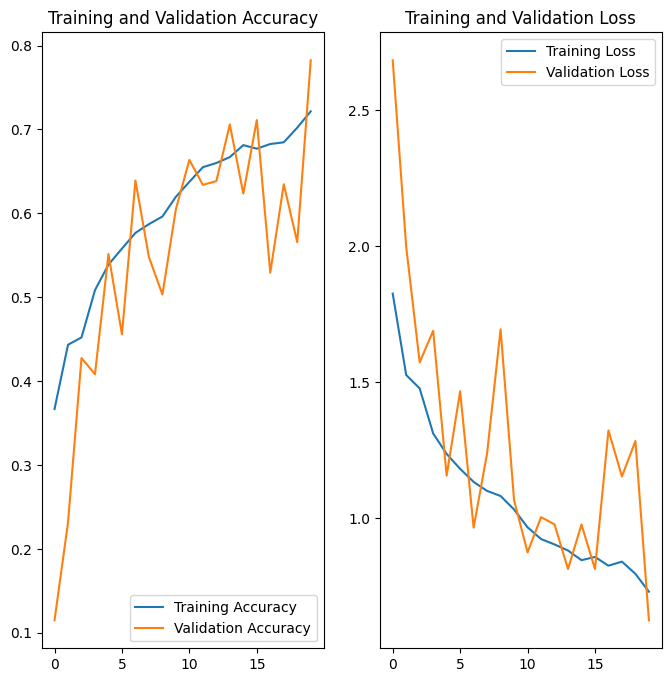

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


### **Observations:**

**Training Accuracy:**

The training accuracy has consistently improved, reaching 71.6% at the end of epoch 20. This indicates that the model is learning and the overall performance is improving.

**Validation Accuracy:**

The validation accuracy shows some fluctuations, but it reached 78.25% by the end of the training. The validation accuracy is higher than the training accuracy in later epochs, which suggests that the model is generalizing well.

**Losses:**

The training loss steadily decreases from 2.1552 to 0.7366.
Validation loss decreases initially but fluctuates toward the end of training, with the final validation loss at 0.6253.
While the model seems to be improving on the training data, the validation loss is still showing variability.

**Learning Rate Scheduling:**

The learning rate is reduced by ReduceLROnPlateau during training, which is a good strategy to fine-tune the model towards the end of training. The learning rate was initially 0.001, and by epoch 20, it had reduced to 0.00025.

#### **Possible Issues:**

**Overfitting:**
The model is not showing signs of overfitting, as the validation accuracy is either equal to or slightly higher than the training accuracy in the later epochs. However, the fluctuations in validation loss might indicate minor overfitting, so it’s worth keeping an eye on this.

**Underfitting:**
The model seems to be learning well, so underfitting is not a major concern, but further tuning of hyperparameters like the learning rate, dropout rates, or adding additional epochs may help improve performance.

### **MODEL PREDICTION**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


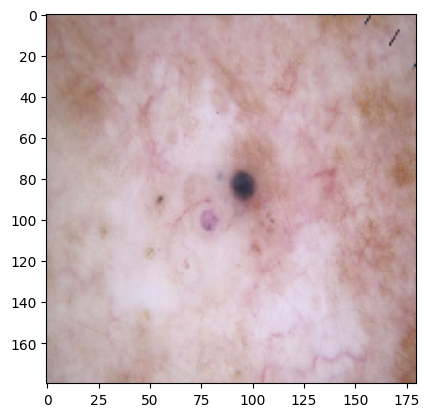

In [36]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )